## Setup dependencies

In [1]:
import sys
import datetime as dt;

# display python version and date/time

print(dt.datetime.today());
print(sys.version)

# google colab specific code
if 'google.colab' in sys.modules:
    try:
        import google.colab
        import subprocess
        import os.path
        p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
        if p.stdout == 'true\n':
            !git pull
        else:
            if not os.path.isdir('city_dsp_ap'):
                !git clone --depth 1 -q https://github.com/tweyde/city_dsp_ap.git
            %cd city_dsp_ap
    except:
        %cd city_dsp_ap
else:
    print("Skipped google colab specific code");

2021-04-13 11:41:19.025967
3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Skipped google colab specific code


In [2]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
from scipy import fft, signal
plt.rcParams['figure.figsize'] = (13,6) # increase the default size of the plots

## Controllable delay line (UG) or filter (PG)

You will need to create a function that applies the desired effect to any input signal, where the effect can be dynamically modified by a control signal. The functions only need to be implemented for offline use, so you don't need to be handle input buffers of arbitrary sizes like in lab 6. It suffices to use a single for loop to run over all samples of the input and control signals, and create the output sample-by-sample.

In both cases, the control signal will be a sine of 2Hz. Create one of the required length yourself. Any signal should work as input signal. You can learn how to [upload your own files](https://colab.research.google.com/notebooks/io.ipynb) into Google Colab, but the easiest will be to use one of the wave files available in the `audio` directory. If you're loading a stereo file, it is allowed to mix it down into a single mono channel before passing it to the effect to simplify processing.

In [3]:

%ls audio

 Volume in drive C is OS
 Volume Serial Number is F287-2376

 Directory of C:\Users\jacqu\city\DS2020\Modules\DigitalSignalProcessing\Coursework\CourseworkWip\audio

25/03/2021  15:06    <DIR>          .
25/03/2021  15:06    <DIR>          ..
13/02/2021  11:45            51,328 20-16000HzExp5sec.mp3
13/02/2021  11:45            51,328 20-16000HzLin5sec.mp3
13/02/2021  11:45            34,660 carrier.wav
13/02/2021  11:45         4,365,330 rockA.wav
25/03/2021  15:05           281,672 rockAShort.wav
13/02/2021  11:45         4,365,396 rockB.wav
25/03/2021  15:06           309,332 rockBShort.wav
               7 File(s)      9,459,046 bytes
               2 Dir(s)  63,767,224,320 bytes free


#### PG
Program a controllable FIR filter, i.e. a filter that changes its characteristics over time in response to a control signal. Apply the filter to the signal by implementing a convolution with the filter coefficients in a loop over the samples, just like in lab 7. In order to make the filter respond to the control signal, you can either design two static filters and interpolate between them (like in lab 7), or you can directly manipulate the filter characteristics in the filter design function [`firls`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) and call it for every iteration.

The following filenames are defined for the wav files used:

In [4]:
# Define wav filenames used:
s1Filename = "audio/carrier.wav"
s2Filename = "audio/rockA.wav"
s3Filename = "audio/rockB.wav"

#### WavClass
A class that encapsulates audio files is coded and tested on the audio samples

In [5]:
#
# Class that encapsulates the wav file functionality:
# - load a wav file
# - plot the wav file's channel(s)
# - convert to mono using correlation
# - plot results of the search for maximum correlation if the loaded stereo sample needs correcting
#
class WavClass:
    # Class properties:
    # samples the samples as read from the wav file
    # sampleRate the sample rate
    # filename the wav file name
    # isMono boolean if mono samples is 1D, False it is 2D
    # samplesMono the samples converted to mono

    def __init__(self, wavFileName=None, doPlots=False, rawSamples=[], rawSampleRate=None):
        if wavFileName != None:
            self.initFromWavFile(wavFileName, doPlots)
        elif len(rawSamples) > 0:
            self.initFromSamples(rawSamples, rawSampleRate, doPlots)
        self.numSamples = len(self.samplesMono)

    # constructor loads the given file, converts it to 1 channel mono if it is stereo
    # plots the sample, and stereo correlation information
    def initFromWavFile(self, wavFileName, doPlots):
        self.sampleRate, samples = wavfile.read(wavFileName);
        # To avoid warnings and errors of the kind:
        #   RuntimeWarning: overflow encountered in short_scalars
        # convert samples from short to float:
        self.samples = samples.astype(np.float)
        self.filename = wavFileName;
        self.doPlots = doPlots
        self.__preprocessSamples__()

    def initFromSamples(self, samples, sampleRate, doPlots):
        self.samples = samples.astype(np.float)
        self.sampleRate = sampleRate
        self.filename = "RawSamplesSUpplied.noFile"
        self.doPlots = doPlots
        self.__preprocessSamples__()

    # Plot stereo samples, and mono samples on the same graph to see the result of
    # a conversion from stereo to mono
    # input stereo: 2d array format: [samples,channel]
    #       monoSamples: 1d array of samples
    #       title: title to give to the plot
    def __plotStereo__(self, title):
        if not self.doPlots:
            return

        fig, ax1 = plt.subplots()
        ax1.set_title(title)
        ax1.plot(self.samples[:,0], label="Ch. 1", alpha=0.35, color='green')
        ax1.plot(self.samples[:,1], label="Ch. 2", alpha=0.35, color='orange')
        ax1.plot(self.samplesMono, label="Mono", alpha=0.35, color='blue')
        ax1.legend(loc = 4)
        ax1.set_xlabel("Sample Number")
        ax1.set_ylabel("Amplitude")
        plt.show()

    # Plot monophonic (mono) samples
    #       title: title to give to the plot
    def __plotMono__(self, title):
        if not self.doPlots:
            return
        fig, ax1 = plt.subplots()
        ax1.set_title(title)
        ax1.plot(self.samplesMono, 'b')
        ax1.set_xlabel("Sample Number")
        ax1.set_ylabel("Amplitude")
        plt.show()

    # Using Audacity, on RockA.wav, it can be seen that the stereo channels are not in phase,
    # and one channel has been inverted. This function finds how many samples to shift and inverts (if needed)
    # the respective channels
    # input:
    #   flipChannel: channel to invert, None if no inversion needed
    #
    def __alignSamples__(self, flipChannel=None):
        correlationCoefficients = np.zeros(self.sampleRate)
        channel1Section = self.samples[0:self.sampleRate,0]
        channel2Section = self.samples[0:self.sampleRate,1]
        channel1RightShift = channel1Section
        maxCoefficient = 0.0
        maxCoefficientIndex = 0

        #Invert the sign of one channel?
        if flipChannel != None:
            self.samples[:,flipChannel] = self.samples[:,flipChannel] * -1
            # check correllation maybe this fixed the correlation
            rawCoeff = np.dot(self.samples[:, 0], self.samples[:, 1]) / np.sqrt(np.dot(self.samples[:, 0], self.samples[:, 0]) * np.dot(self.samples[:, 1], self.samples[:, 1]))
            if abs(rawCoeff) > 0.8:
                return

        # loop shifting channel 1 to the right to find the highest correlation coefficient between channel 1 & 2
        for offset in range(0,int(self.sampleRate/10)):
            #rawCoeff = np.dot(self.samples[:, 0], self.samples[:, 1]) / np.sqrt(np.dot(self.samples[:, 0], self.samples[:, 0]) * np.dot(self.samples[:, 1], self.samples[:, 1]))
            # calculate the correlation coefficient of the two channels at the currently shifted position
            correlationCoefficients[offset] = np.dot(channel1RightShift, channel2Section) / np.sqrt(np.dot(channel1RightShift, channel1RightShift) * np.dot(channel2Section, channel2Section))
            channel1RightShift = np.concatenate([np.zeros(1), channel1RightShift])
            channel2Section = np.concatenate([channel2Section, np.zeros(1)])
            if maxCoefficient < correlationCoefficients[offset]:
                maxCoefficient = correlationCoefficients[offset]
                maxCoefficientIndex = offset
        self.__plotChannelAlignmentCorrelationCoefficientSearch__(correlationCoefficients, maxCoefficientIndex)
        # if the correlation coefficient is > 0.8, we can correct the stereo sample
        if maxCoefficient > 0.8:
            # channel1 is inverted & prepended with maxCoefficientIndex zeros (right shifted)
            channel1 = self.samples[:,0]
            channel1 = np.concatenate((np.zeros(maxCoefficientIndex), channel1), axis=None)
            # channel 2 is appended with zeros to make length same as channel1
            channel2 = self.samples[:,1]
            channel2 = np.concatenate((channel2, np.zeros(maxCoefficientIndex)), axis=None)
            # new in phase stereo is constructed
            self.samples = np.transpose(np.array([channel1, channel2]))

    # plot the results of the search for the maximum correlation coefficient
    # Input: correlationCoefficients 1d array of correlation coefficients
    #        maxCoefficientIndex index in the array of the correlation coefficient that is the largest
    def __plotChannelAlignmentCorrelationCoefficientSearch__(self, correlationCoefficients, maxCoefficientIndex):
        if not self.doPlots:
            return
        # plot all correlation coefficients calculated
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(correlationCoefficients[0:maxCoefficientIndex + 10])
        ax.set_title("correlationCoefficients")
        ax.set_xlabel("Channel 1 right shift value")
        ax.set_ylabel("Channel 1&2 correlation coefficient")

        # set xaxis labels
        ticks = np.array(range(maxCoefficientIndex + 10))
        labels = ticks.astype(str)
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
        plt.grid()
        plt.show()
        print("Max coefficient: ", correlationCoefficients[0:maxCoefficientIndex])

    # check DC offset of sample channels is approximately zero, if not, adjust the offset
    # if the samples member is two dimensional, try converting to mono
    # stores the conversion to mono in self.samplesMono
    def __preprocessSamples__(self):
        if (self.samples.ndim == 2):
            display("Read file: {} {} samples, rate {}".format(self.filename, len(self.samples[:, 0]), self.sampleRate))
            mean1 = np.mean(self.samples[:, 0])
            mean2 = np.mean(self.samples[:, 0])
            # adjust DC offset?
            if abs(mean1) > 0.1:
                display("Adjusting DC offset Channel0 Mean: {} Variance: {} Std Dev: {} median {}".format(np.mean(self.samples[:, 0]),
                                                                                  np.var(self.samples[:, 0]),
                                                                                  np.std(self.samples[:, 0]),
                                                                                  np.median(self.samples[:, 0])))
                self.samples[:,0] = self.samples[:,0] - mean1
            if abs(mean2) > 0.1:
                display("Adjusting DC offset Channel1 Mean: {} Variance: {} Std Dev: {}".format(np.mean(self.samples[:, 1]),
                                                                        np.var(self.samples[:, 1]),
                                                                        np.std(self.samples[:, 1]),
                                                                        np.median(self.samples[:, 0])))
                self.samples[:, 1] = self.samples[:, 1] - mean1
            self.__convertToMono__()
        else:
            display("Read file: {} {} samples, rate {}".format(self.filename, len(self.samples), self.sampleRate))
            mean = np.mean(self.samples)
            if mean > abs(0.1):
                #adjust dc offset
                display("Adjusting DC offset. Channel Mean: {} Variance: {} Std Dev: {}".format(np.mean(self.samples),
                                                                      np.var(self.samples),
                                                                      np.std(self.samples),
                                                                      np.median(self.samples)))
                self.samples = self.samples - mean
            self.samplesMono = self.samples
            self.__plotMono__("One Channel Sample File Plot")


    # Convert the stereo sample to a mono sample, displays a plot of samples and conversion
    # store the mono version in self.samplesMono
    # expects self.samples to be 2 dimensional
    def __convertToMono__(self):
        display("Convert to mono: {}".format(self.filename))
        # calculate correlation coefficient
        rawCoeff = np.dot(self.samples[:, 0], self.samples[:, 1]) / np.sqrt(np.dot(self.samples[:, 0], self.samples[:, 0]) * np.dot(self.samples[:, 1], self.samples[:, 1]))
        self.samplesMono = self.samples[:, 0] / 2 + self.samples[:, 1] / 2;
        if abs(rawCoeff) >= 0.8:
            # no need to correct the samples
            # plot them:
            self.__plotStereo__("Good conversion to mono abs(correlation coefficient) >= 0.8: {}".format(abs(rawCoeff)));
        else:
            # samples need correcting, plot the original:
            self.__plotStereo__("Poor conversion to mono abs(correlation coefficient) < 0.8, needs phase alignment: {}".format(abs(rawCoeff)))
            # correct the samples
            if (rawCoeff < 0):
                # negative value implies there is cancellation happening, invert one of the channels
                # as well as checking for correlation again, possibly shifting one channel
                display("One channel needs inverting, the correlation coefficient is < 0")
                self.__alignSamples__(flipChannel=0)
            else:
                # no inverting the sign of one channel is needed, but shifting one channel may be necessary
                self.__alignSamples()

            # now the samples have been preprocessed, convert the channels to mono into self.monoSamples
            # convert to mono
            self.samplesMono = self.samples[:, 0]/2 + self.samples[:, 1]/2;
            # plot the corrected samples
            self.__plotStereo__("Aligned conversion to mono (correlation coefficient was < 0.8): {}".format(abs(rawCoeff)))
        self.__plotMono__("Resulting Mono Sample")


#### Load carrier.wav

'Read file: audio/carrier.wav 34616 samples, rate 12000'

'Adjusting DC offset. Channel Mean: 135.74768892997457 Variance: 1087.9363391239426 Std Dev: 32.98387998892706'

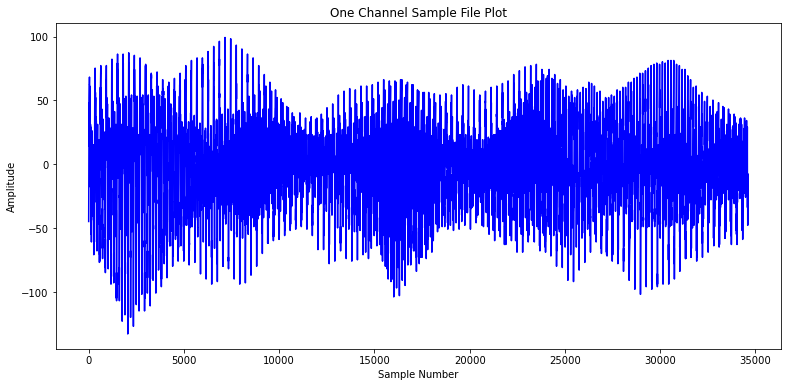

In [6]:
wavClass = WavClass(s1Filename, doPlots=True)
display(Audio(wavClass.samples, rate=wavClass.sampleRate));


#### Notes
- The file carrier.wav has only one channel (mono)
- Sampling rate is 12000 samples per second
- 34616 samples
- The mean value of the samples is 135.75, it should be appriximately zero. The DC offset was adjusted by subtracting the mean from the samples

#### Load rockA.wav


'Read file: audio/rockA.wav 545652 samples, rate 44100'

'Convert to mono: audio/rockA.wav'

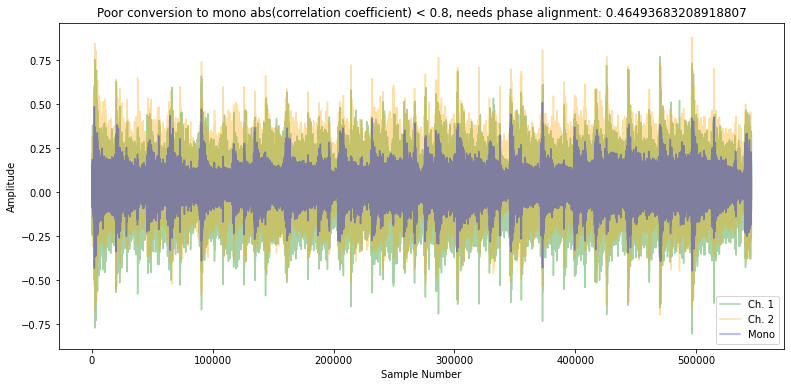

'One channel needs inverting, the correlation coefficient is < 0'

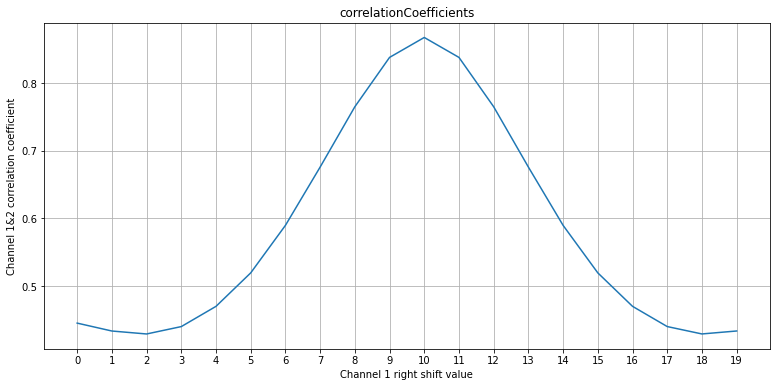

Max coefficient:  [0.44506161 0.43338292 0.42900826 0.43993318 0.46984473 0.51931617
 0.58956092 0.6757242  0.76489066 0.83783633]


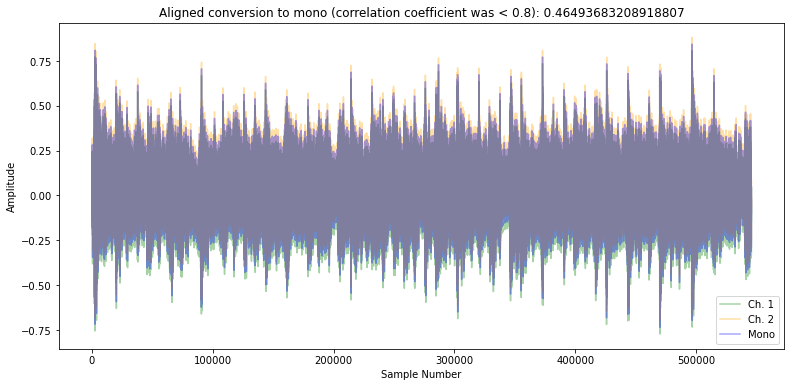

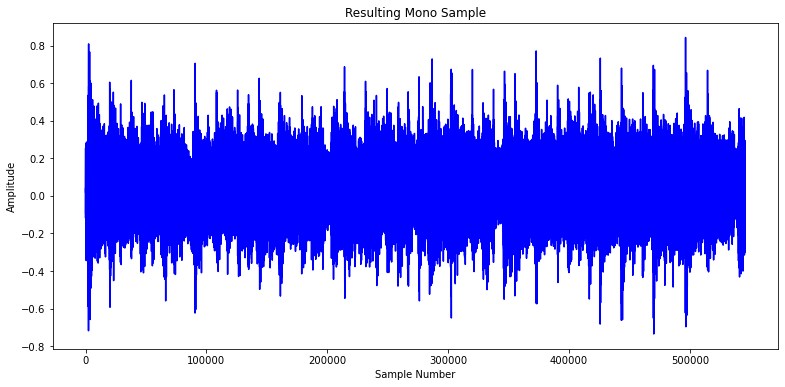

In [7]:
wavClass = WavClass(s2Filename, doPlots=True)
display(Audio(wavClass.samplesMono, rate=wavClass.sampleRate));

#### Notes
- The file RockA.wav is stereo, 44100 samples per second sampling rate, 545652 samples per channel.
- The plot displays the first audio channel, overlays the second audio channel, then finally overlays the result of
combining both channels to a single mono channel.
- The effect of the poor correlation between the two channels
is clearly visible.
- The correlation coefficient of of the channels is poor: -0.4649.
- The file samples are corrected: channel 1 is inverted and shifted to the right by the number of samples that
give the highest correlation coefficient.
- The corrected stereo sample is converted to mono: The corrected stereo sample is plotted to show the effect of correcting the sample
before converting it to mono.
- After conversion there are 10 more samples, due to shifting one channel and zero padding the other.

The correlation coefficient search is based on Steven W. Smith, Digital Signal Processing, Chapter 7, Correlation radar example.

#### Load rockB.wav

'Read file: audio/rockB.wav 545652 samples, rate 44100'

'Convert to mono: audio/rockB.wav'

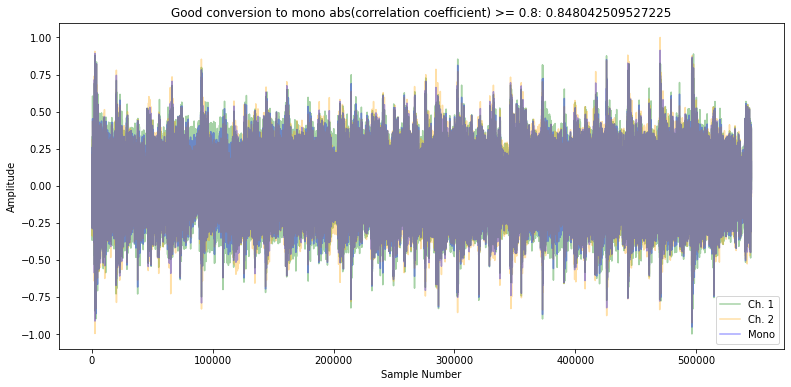

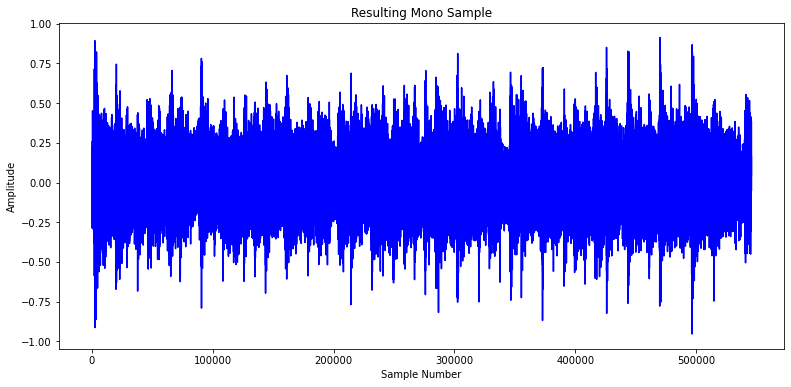

In [8]:
wavClass = WavClass(s3Filename, doPlots = True)
display(Audio(wavClass.samplesMono, rate=wavClass.sampleRate));

#### Notes
- The file RockB.wav is stereo, 545652 samples per channel, 44100 samples/second sampling rate
- There is a good correlation (0.84804) between the two channels.
- The graph shows that the conversion closely
matches the two channels.
- The audio rendered is a good combination of both channels.

#### ControlClass
A class is coded to implement a control signal that is used by the modulated FIR filter

In [9]:
class ControlClass:

    # generate a repeating sine control:
    # size of control signal might as well be the same as the sample size
    # Input:
    #  sampleRate: sample rate of signal to produce (44100 is common)
    #  numSamples: the size of the array of sines to return
    #  frequency: the frequency of the sine wave(s) wanted
    #  amplitude: the maximum value of the sine
    # Sets member:
    #  self.controlSignal: array of repeating sines
    def __init__(self, sampleRate, numSamples, frequencyHz=2, maxAmplitude=1.0, doPlot=False):
        self.sampleRate = sampleRate
        self.numSamples = numSamples
        self.frequency = frequencyHz
        self.maxAmplitude = maxAmplitude

        # number points for 2hz sine for given sample rate:
        numPoints = sampleRate / frequencyHz  # eg: 2 hertz = 2 samples per second
        # points needed to represent the sine control signal:
        timepoints = np.arange(0, 1, 1 / numPoints)
        # convert the 0-1 values to sine(0-1):
        controlSignal = np.sin(2 * np.pi * frequencyHz * timepoints)
        # apply amplitude factor to sines:
        controlSignal = controlSignal * maxAmplitude
        # repeat the sines to build an array at least as long as numSamples
        repeats = int(numSamples / len(controlSignal)) + 1
        controlSignal = np.tile(controlSignal, repeats)
        # trim off extra values
        controlSignal = controlSignal[:numSamples]
        # plot control signal:
        self.controlSignal = controlSignal
        if doPlot:
            self.plotControlSignal()
        # return control signal:


    # plot the control signal
    def plotControlSignal(self):
        plt.figure()
        plt.plot(self.controlSignal)
        plt.title("Control Signal (sine {}Hz) s.rate {}, len. {}".format(self.frequency, self.sampleRate, self.numSamples))
        plt.xlabel("Sample Number")
        plt.ylabel('Amplitude')
        plt.ylim(top=1)
        plt.show()

    # when convolution is performed, the index goes beyond the
    # length of the input signal by definition of convolution
    # this method reflects back in this case
    def getControlFactor(self, controlIndex):
        if (controlIndex >= self.numSamples):
            controlIndex = (self.numSamples % controlIndex) - self.numSamples
        return self.controlSignal[controlIndex % self.numSamples]

    # interpolate 2 filters using the given controlFactor (between 0 and 1)
    # return the interpolated filter
    def interpolateFilters(self, controlIndex, filterMin, filterMax):
        controlFactor = self.getControlFactor(controlIndex)
        interpolated1 = filterMin * controlFactor
        interpolated2 = filterMax * (1 - controlFactor)
        return interpolated1 + interpolated2

#### Test the ControlClass

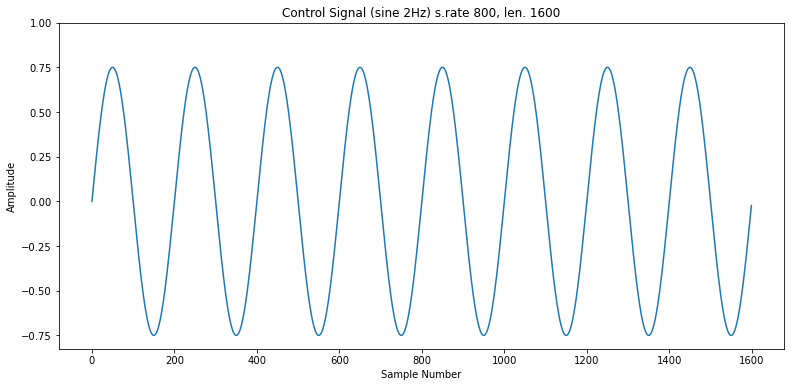

In [10]:
control = ControlClass(sampleRate=800, numSamples=1600, maxAmplitude=0.75, doPlot=True)

#### Notes
Given a sample rate of 800 samples per second, 1600 samples, a maximum control amplitude of 0.75
, the control class creates a member variable controlSignal:
An array of 1600 values that represent sine waves that fill the array, for the requested frequency.

#### ConvolutionClass
A convolution class is coded to perform the convolution of a signal with a filter.
W. Smith, Digital signal processing, Chapter 6, explains input side and output side convolution. Both methods are implemented.
 The convolution integrates modulation by a control signal, and is capable of performing convolution on
 a mono or stereo signal.

In [11]:
class ConvolutionClass:

    # Constructor:
    # filter1 is the
    def __init__(self, filter1, filter2, control):
        self.filter1 = filter1
        self.filter2 = filter2
        self.control = control

    # output of convolution is the length of the signal + the length of the filter kernel - 1
    # W. Smith, Digital signal processing, Chapter 6.
    def convolveInputSide(self, signal):
        isStereo = False
        filterLength = len(self.filter1)
        if signal.ndim == 2:
            signalLength = len(signal[:,0])
            output = np.zeros(signalLength + filterLength - 1)
            isStereo = True
            output = np.transpose(np.array([output, output]))
        else:
            signalLength = len(signal)
            output = np.zeros(signalLength + filterLength - 1)


        for signalIndex in range(signalLength):
            for kernelIndex in range(filterLength):
                # create interpolated filter using the control signal as a factor for interpolation
                filter = self.control.interpolateFilters(signalIndex, self.filter1, self.filter2)
                if isStereo:
                    output[signalIndex + kernelIndex, 0] = output[signalIndex + kernelIndex, 0] + signal[signalIndex, 0] * \
                                                        filter[kernelIndex]
                    output[signalIndex + kernelIndex, 1] = output[signalIndex + kernelIndex, 1] + signal[signalIndex, 1] * \
                                                        filter[kernelIndex]
                else:
                    output[signalIndex + kernelIndex] = output[signalIndex + kernelIndex] + signal[signalIndex] * \
                                                        filter[kernelIndex]
        if isStereo:
            return output[:-(len(filter) - 1),:]
        else:
            return output[:-(len(filter) - 1)]

    # output of convolution is the length of the signal + the length of the filter kernel - 1
    # W. Smith, Digital signal processing, Chapter 6.
    def convolveOutputSide(self, signal):
        isStereo = False
        filterLength = len(self.filter1)
        if signal.ndim == 2:
            signalLength = len(signal[:, 0])
            output = np.zeros(signalLength + filterLength - 1)
            isStereo = True
            output = np.transpose(np.array([output, output]))

        else:
            signalLength = len(signal)
            output = np.zeros(signalLength + filterLength - 1)


        outputRange = signalLength + filterLength - 1
        kernelRange = len(self.filter1)
        for outputIndex in range(outputRange):
            for kernelIndex in range(kernelRange):
                filter = self.control.interpolateFilters(outputIndex, self.filter1, self.filter2)
                if (outputIndex - kernelIndex < 0) or (outputIndex - kernelIndex > (len(signal) - 1)):
                    # don't do anything
                    pass
                else:
                    if isStereo:
                        output[outputIndex, 0] = output[outputIndex, 0] + filter[kernelIndex] * signal[
                            outputIndex - kernelIndex, 0]
                        output[outputIndex, 1] = output[outputIndex, 1] + filter[kernelIndex] * signal[
                            outputIndex - kernelIndex, 1]
                    else:
                        output[outputIndex] = output[outputIndex] + filter[kernelIndex] * signal[outputIndex - kernelIndex]
        if isStereo:
            return output[:-(len(self.filter1) - 1), :]
        else:
            return output[:-(len(self.filter1) - 1)]

    # expects 1d signal
    def __plotTwoSignals__(self, signal1, signal2, title):
        plt.figure()
        plt.plot(signal1, 'r', label='Original')
        plt.plot(signal2, 'b', alpha=0.5, label='Filtered')
        plt.title(title)
        plt.legend(loc=4)
        plt.xlabel("Sample Number");
        plt.ylabel("Amplitude");
        plt.show()

    def __plotTwoSignals__(self, signal1, signal2, title):
        plt.figure()
        plt.plot(signal1, 'r', label='Original')
        plt.plot(signal2, 'b', alpha=0.5, label='Filtered')
        plt.title(title)
        plt.legend(loc=4)
        plt.xlabel("Sample Number");
        plt.ylabel("Amplitude");
        plt.show()

    def plotTwoSignals(self, signal1, signal2, title):
        if signal1.ndim == 2:
            title1 = "{} Channel 1".format(title)
            self.__plotTwoSignals__(signal1[:,0], signal2[:,0], title1)
            title2 = "{} Channel 2".format(title)
            self.__plotTwoSignals__(signal1[:, 1], signal2[:, 1], title2)
        else:
            self.__plotTwoSignals__(signal1, signal2, title)

#### CombFilterClass
Finally a comb filter class is implemented that is capable of taking a sample, and applying a filter to it.

In [12]:
#
# Modulated Comb filter class (flanger): modulated between 2 filters whose
# delay is above 20 Hz in order to create a flanging effect
#
class CombFilterClass:

    #
    # constructor.
    # controlClass: the control signal calss instance used to modulate the filter
    # minDelay: minimum signal delay produced
    # maxDelay: maximum signal delay produced
    # filterSize: size of the filter to create
    # doPlot plot filter created: True yes, False no.
    def __init__(self, controlClass, minDelay=2, maxDelay=1022, filterSize=1024, doPlot=False):
        self.doPlot = doPlot
        # impulse signal for filter1
        filterMin = np.zeros(filterSize)
        filterMin[0] = 1
        filterMin[minDelay] = 0.75
        # impulse signal for filter 2
        filterMax = np.zeros(filterSize)
        filterMax[0] = 1
        filterMax[maxDelay] = 0.75
        self.filterMin = filterMin
        self.filterMax = filterMax
        if (self.doPlot):
            self.plotFilters()

        self.convolutionClass = ConvolutionClass(filterMin, filterMax, controlClass)

    # plot the given filters, overlayed
    def plotFilters(self):
        # plot the filters' frequency spectrum
        minFft = fft.rfft(self.filterMin)
        maxFft = fft.rfft(self.filterMax)
        fig = plt.figure()
        plt.title("Comb Filter Frequency Spectra")
        plt.plot(minFft, 'r', alpha=0.5, label='Min Filter')
        plt.plot(maxFft, 'b', alpha=0.5, label='Max Filter')
        plt.xlabel("Frequency")
        plt.ylabel('Amplitude')
        plt.legend(loc=4)
        fig.show()

        fig = plt.figure()
        plt.title("Comb Filter Impulse Response Plot")
        plt.plot(self.filterMin, 'r', alpha=0.5, label="Min Filter")
        plt.plot(self.filterMax, 'b', alpha=0.5, label="Max Filter")
        plt.xlabel("Impulse Sample No.")
        plt.ylabel('Amplitude')
        plt.legend(loc=4)
        fig.show()

    # Plot original signal and filtered signal
    # newSamples filtered signal
    # samples original signal
    # title title of the plot
    def plotOriginalAndConvolved(self, newSamples, samples, title):
        fig = plt.figure()
        plt.plot(samples, 'r', label='Original')
        plt.plot(newSamples, 'b', alpha=0.5, label='Filtered')
        plt.title(title)
        plt.legend(loc=4)
        plt.xlabel("Sample Number");
        plt.ylabel("Amplitude");
        fig.show()

    # Modulated filter of signal, using an interpolation of filter1 and filter2
    # using the control as the interpolation factor.
    # Convolution based on: W. Smith, Digital signal processing, Chapter 6. Input side convolution
    #
    # signal the signal to modulate
    # return filtered signal
    def filterAudioInputSide(self, signal):
        conv = self.convolutionClass.convolveInputSide(signal)
        return conv

    # Modulated filter of signal, using an interpolation of filter1 and filter2
    # using the control as the interpolation factor.
    # Convolution based on: W. Smith, Digital signal processing, Chapter 6. Output side convolution
    #
    # signal the signal to modulate
    # return filtered signal
    def filterAudioOutputSide(self, signal):
        conv = self.convolutionClass.convolveOutputSide(signal)
        return conv

    #
    # taken from lab5: plot a spectogram of the time signal (frequency over time, amplitude is the color)
    # time_signal samples to convert to frequency domain
    # samplerate: sampling rate of the signal
    # title the title to give to the plot
    def plot_spectrogram(self, time_signal, samplerate, title=''):
        frequencies, timepoints, specgram = signal.stft(time_signal, fs=samplerate, nperseg=1024)
        power_spectrogram = 20 * np.log10(np.abs(specgram) + np.finfo(float).eps)
        # adding a small number before applying log10 avoids divide by zero errors
        fig = plt.figure()
        plt.pcolormesh(timepoints, frequencies, power_spectrogram, vmin=-99, vmax=0)
        plt.title(title)
        plt.ylabel('frequency [Hz]')
        plt.xlabel('time [s]')
        #     plt.xlim(0.5e7, 0.7e7) # adjust the x-axis to zoom in on a specific time region
        #     plt.xlim(5e7, 5.5e7)
        #     plt.ylim(0, 0.0005) # adjust the y-axis range to zoom in on low frequencies
        fig.show()


### Input Side Convolution
Input side convolution is performed on the Carrier.wav (mono) audio:

'Read file: audio/carrier.wav 34616 samples, rate 12000'

'Adjusting DC offset. Channel Mean: 135.74768892997457 Variance: 1087.9363391239426 Std Dev: 32.98387998892706'

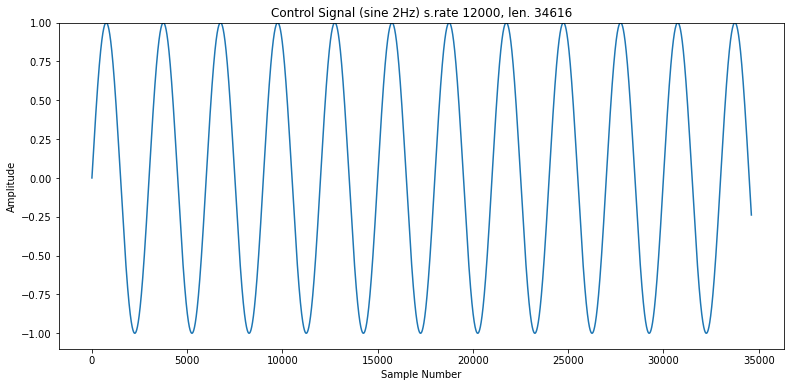

C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


'Read file: RawSamplesSUpplied.noFile 34616 samples, rate 12000'

C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:98: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


'Result of filtering:'

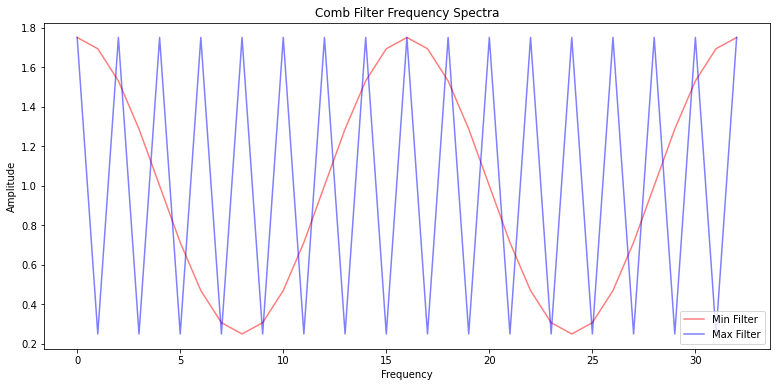

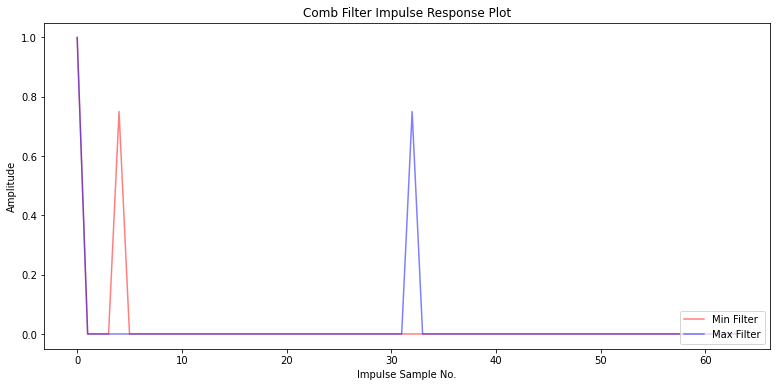

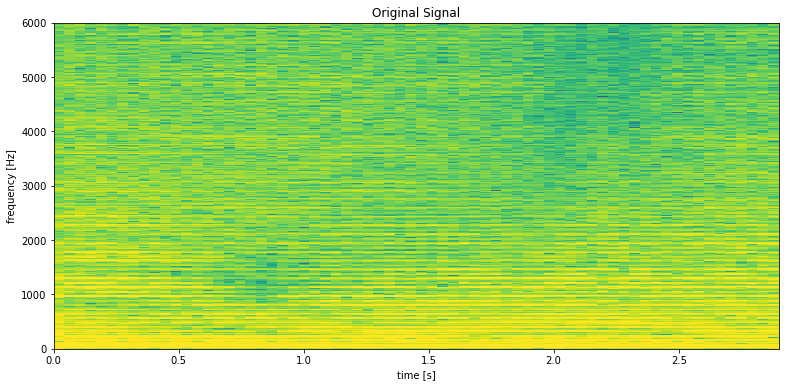

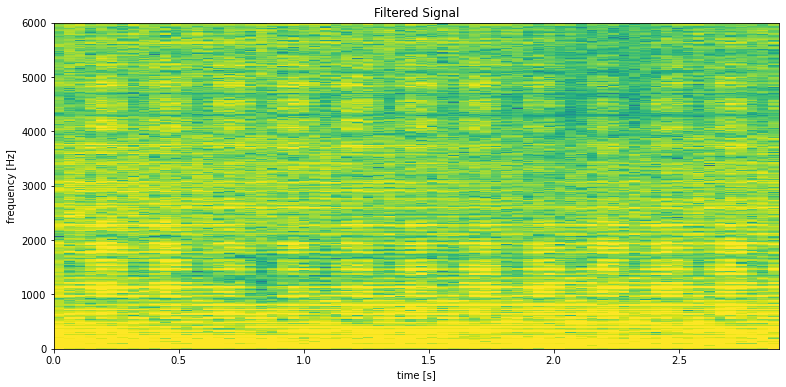

In [13]:
# load carrier.wav
wavClass = WavClass(wavFileName=s1Filename, doPlots=False)
# create the control (LFO) class
controlClass = ControlClass(wavClass.sampleRate, wavClass.numSamples, frequencyHz=2, maxAmplitude=1.0, doPlot=True)
# create the comb filter
filter = CombFilterClass(controlClass, minDelay=4, maxDelay=32, filterSize=64, doPlot=True)
# filter the signal
newSamples = filter.filterAudioInputSide(wavClass.samplesMono)
# display the result of the filter
newWavClass = WavClass(rawSamples=newSamples, rawSampleRate=wavClass.sampleRate)
#filter.plotOriginalAndConvolved(newSamples, wavClass.samplesMono, "Original and Filtered Signal")
filter.plot_spectrogram(wavClass.samplesMono, wavClass.sampleRate, "Original Signal")
filter.plot_spectrogram(newWavClass.samplesMono, newWavClass.sampleRate, "Filtered Signal")
display("Result of filtering:")
display(Audio(newWavClass.samples, rate=newWavClass.sampleRate))

#### Notes
Comparing the filtered signal to the original signal in the frquency domain, a pattern in the filtered signal is visible:
- The control frequency is 2 Hz, the plot shows the pattern happening two times per second.
- The comb filter is visible in the horizontal bands.
- The control modulation of the signal can be seen as alternating set of horizontal bands, oscillating between
  high and low amplitude values for each frequency band of the filter.

### Output Side Convolution on RockA.wav (converted to mono)

'Read file: audio/rockA.wav 545652 samples, rate 44100'

'Convert to mono: audio/rockA.wav'

'One channel needs inverting, the correlation coefficient is < 0'

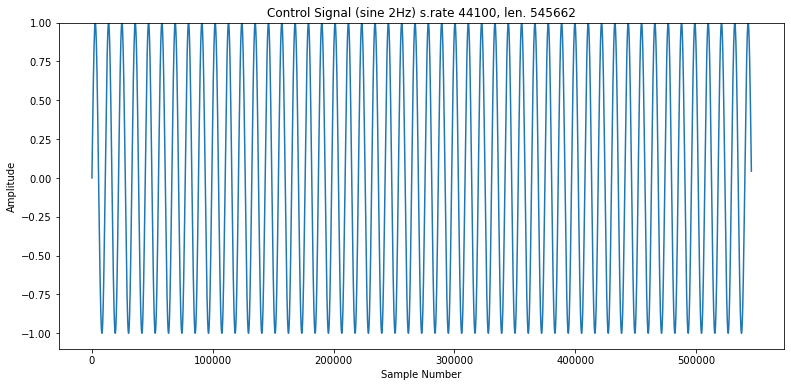

C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


'Read file: RawSamplesSUpplied.noFile 545662 samples, rate 44100'

C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:98: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


'Result of filtering:'

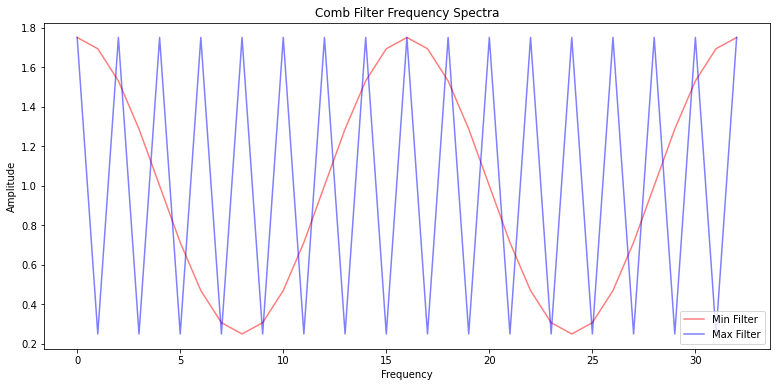

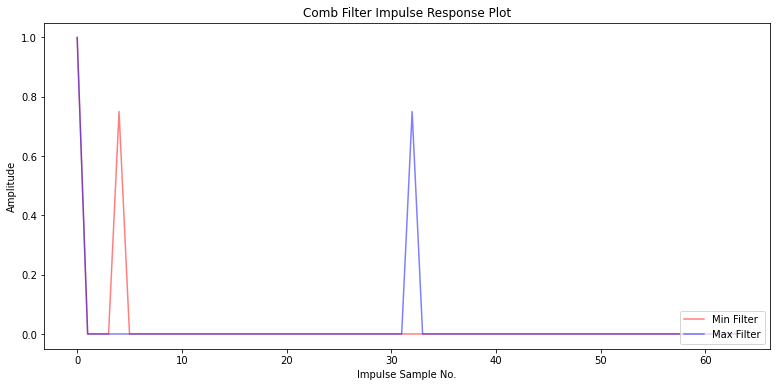

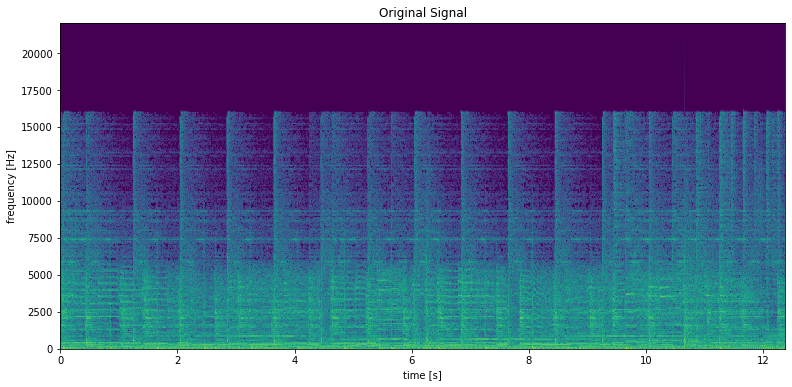

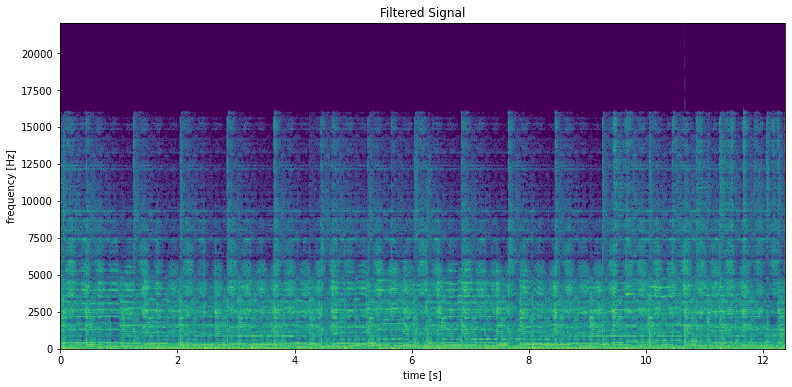

In [14]:
# load rockA.wav
wavClass = WavClass(wavFileName=s2Filename, doPlots=False)
# create the control (LFO) class
controlClass = ControlClass(wavClass.sampleRate, wavClass.numSamples, frequencyHz=2, maxAmplitude=1.0, doPlot=True)
# create the comb filter
filter = CombFilterClass(controlClass, minDelay=4, maxDelay=32, filterSize=64, doPlot=True)
# filter the signal
newSamples = filter.filterAudioInputSide(wavClass.samplesMono)
# display the result of the filter
newWavClass = WavClass(rawSamples=newSamples, rawSampleRate=wavClass.sampleRate)
filter.plot_spectrogram(wavClass.samplesMono, wavClass.sampleRate, "Original Signal")
filter.plot_spectrogram(newWavClass.samplesMono, newWavClass.sampleRate, "Filtered Signal")
display("Result of filtering:")
display(Audio(newWavClass.samples, rate=newWavClass.sampleRate))

####Notes
The filtered signal's frequency response shows the effect of oscillarting filter on the signal.

### Output Side Convolution on RockB.wav (converted to mono)

'Read file: audio/rockB.wav 545652 samples, rate 44100'

'Convert to mono: audio/rockB.wav'

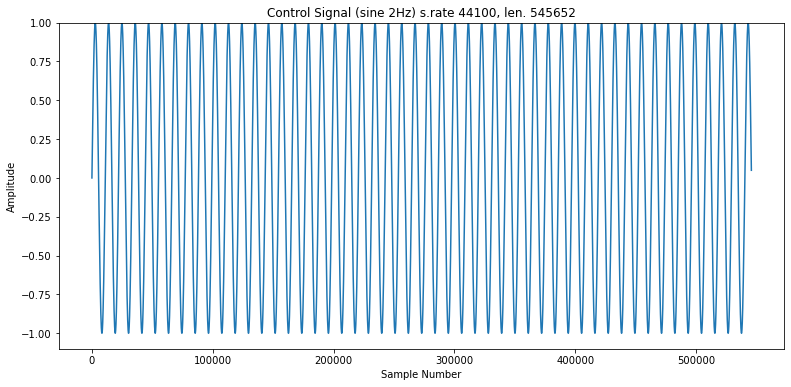

C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


'Read file: RawSamplesSUpplied.noFile 545652 samples, rate 44100'

C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:98: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\jacqu\anaconda3\envs\DSP_Labs\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


'Result of filtering:'

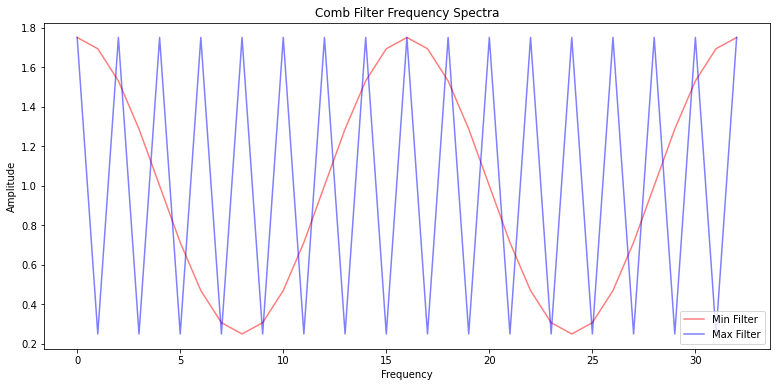

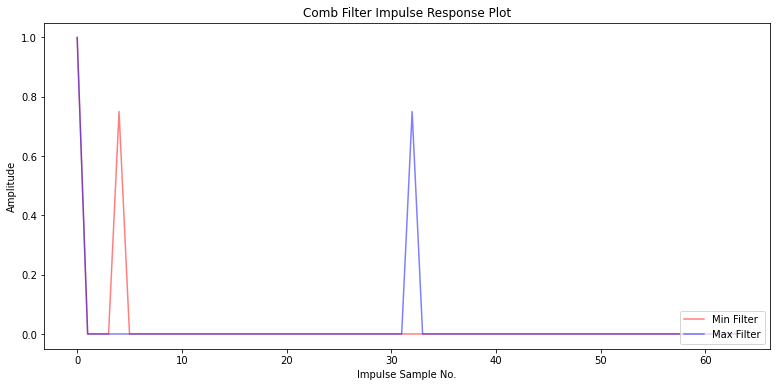

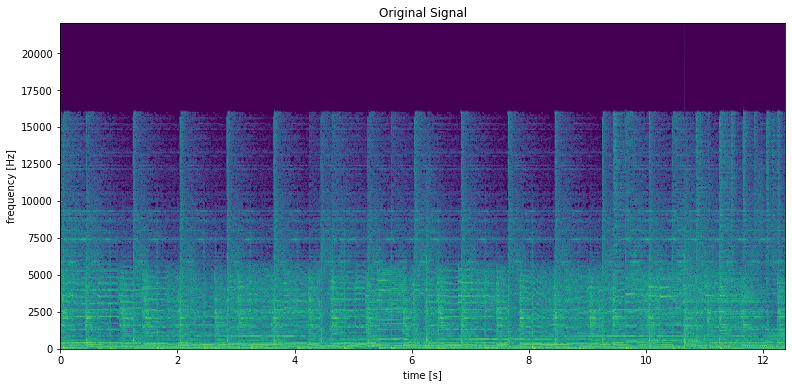

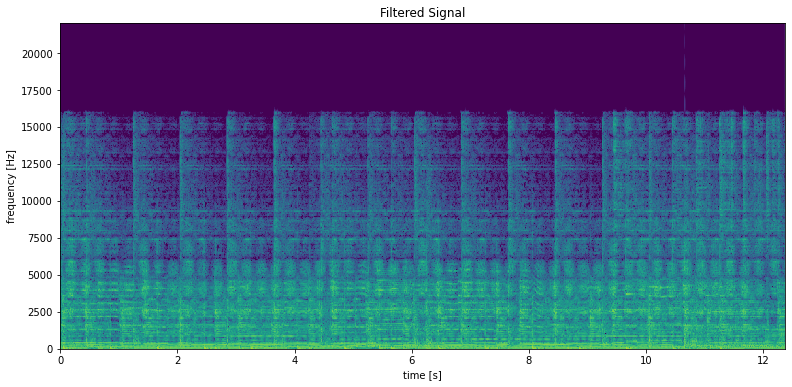

In [15]:
# load rockB.wav
wavClass = WavClass(wavFileName=s3Filename, doPlots=False)
# create the control (LFO) class
controlClass = ControlClass(wavClass.sampleRate, wavClass.numSamples, frequencyHz=2, maxAmplitude=1.0, doPlot=True)
# create the comb filter
filter = CombFilterClass(controlClass, minDelay=4, maxDelay=32, filterSize=64, doPlot=True)
# filter the signal
newSamples = filter.filterAudioInputSide(wavClass.samplesMono)
# display the result of the filter
newWavClass = WavClass(rawSamples=newSamples, rawSampleRate=wavClass.sampleRate)
filter.plot_spectrogram(wavClass.samplesMono, wavClass.sampleRate, "Original Signal")
filter.plot_spectrogram(newWavClass.samplesMono, newWavClass.sampleRate, "Filtered Signal")
display("Result of filtering:")
display(Audio(newWavClass.samples, rate=newWavClass.sampleRate))

## Digit recognition (UG & PG)

In this part, you're going to use images of handwritten digits ranging from 0 to 9. They are split in a training set and a test set and stored as text files in `data/digits-training.txt` and `data/digits-test.txt`.

In [16]:
# Repeat initialisations to allow running from this section
import sys
import datetime as dt;
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
from scipy import fft
plt.rcParams['figure.figsize'] = (13,6) # increase the default size of the plots

# display python version and date/time

print(dt.datetime.today());
print(sys.version)

# google colab specific code
if 'google.colab' in sys.modules:
    %ls data/digits-*.txt
else:
    %ls data

2021-04-13 11:45:50.711324
3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
 Volume in drive C is OS
 Volume Serial Number is F287-2376

 Directory of C:\Users\jacqu\city\DS2020\Modules\DigitalSignalProcessing\Coursework\CourseworkWip\data

13/02/2021  16:30    <DIR>          .
13/02/2021  16:30    <DIR>          ..
13/02/2021  11:45         1,934,417 digits-test.txt
13/02/2021  11:45         3,966,946 digits-training.txt
13/02/2021  11:45         1,048,736 energy_usage.pkl
13/02/2021  11:45           119,126 financial_data.csv
13/02/2021  16:30    <DIR>          images
13/02/2021  11:45        15,604,951 power_consumption.csv
               5 File(s)     22,674,176 bytes
               3 Dir(s)  63,744,602,112 bytes free


### ImageClass
A class is implemented to wrap the folowwing:
- load images from the custom format (the provided loader function `read_digit_pixels_and_labels`
  is refactored as 'readImages' in the class.
- a copy method is provided
- methods to plot the images are present
- methods to process the images: rotate, offset, add noise, and convert to negative representations

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import skimage.transform as imgTransform
import skimage.util as imgUtil
from itertools import islice
import re

#
# Class to encapsulate a set of images: loads a set of digit images and their labels
# self.digitPixels[] holds all the images, each one a 32x32 pixel array
# self.digitLabels[] holds the digit labels that correspond to the images
#
class ImageClass:

    # constructor
    def __init__(self):
        print("Image class init")

    # create a deep copy of this class
    # startIndex, endIndex, optional subset of images to copy to the new ImageClass instance, all are copied by default
    # return the new copy of ImageClass
    def copy(self, startIndex=0, endIndex=-1):
        copy = ImageClass()
        copy.digitPixels = self.digitPixels.copy()
        copy.digitLabels = self.digitLabels.copy()
        if startIndex != 0 or endIndex != -1:
            copy.digitPixels = copy.digitPixels[startIndex:endIndex]
            copy.digitLabels = copy.digitLabels[startIndex:endIndex]
        return copy

    # Code refactored from the coursework's read_digit_pixels_and_labels() function
    # load all the images in the given file
    # sets self.digitPixels[] and self.digitLabels[] to the image data and labels
    # filename the file that holds the images and labels to read.
    # stores the images in self.digitPixels and labels in self.digitLabels
    def readImages(self, filename):
        with open(filename) as f:
            header = list(islice(f, 21))
            pixel_height = [int(x[1]) for x in map(lambda r: re.match('entheight = (\d+)', r), header) if x][0]
            num_digits = [int(x[1]) for x in map(lambda r: re.match('ntot = (\d+)', r), header) if x][0]
            self.digitPixels = []
            self.digitLabels = []
            for _ in range(num_digits):
                chunk = list(islice(f, pixel_height + 1))
                self.digitPixels.append(np.loadtxt(chunk[:-1]))
                self.digitLabels.append(int(chunk[-1]))

            display("Loaded {} images and {} labels.".format(len(self.digitPixels), len(self.digitLabels)))

    #
    #   display the requested image
    #
    def displayImage(self,imageIndex):
        plt.figure()
        plt.imshow(self.digitPixels[imageIndex])
        plt.show()
        print('Image of digit {}'.format(self.digitLabels[imageIndex]))

    # displays images, 4 to a row.
    # imageIndeces an optional set of inage indeces to display: default is ALL images
    def displayImages(self, imageIndeces=None):
        if imageIndeces == None:
            imageIndeces = range(0, len(self.digitPixels))
        columns = 4
        rows = int(len(imageIndeces) / 4) + int(len(imageIndeces) % 4)
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.6)
        for imageIndex in range(1, len(imageIndeces)):
            ax = fig.add_subplot(rows, columns, imageIndex)
            ax.imshow(self.digitPixels[imageIndex])
            ax.title.set_text("Label {}".format(self.digitLabels[imageIndex]))
            ax.set(yticklabels=[])
            ax.set(xticklabels=[])
        plt.show()

    # converts this class' images to negatives of the images
    # returns an instance of this class, as a convenience
    def convertImagesToNegativeImages(self):
        negatives = []
        for originalImage in self.digitPixels:
            negatives.append((originalImage - 1) * -1)
        self.digitPixels = negatives
        return self

    # rotates this class' images anticlockwise by the number of degrees requested
    # angle the number of degrees to rotate the image
    # returns an instance of this class, as a convenience
    def rotateImages(self, angle):
        rotated = []
        for originalImage in self.digitPixels:
            rotated.append(imgTransform.rotate(originalImage, angle, resize=False, center=None))
        self.digitPixels =  rotated
        return self

    # adds noise to all of this class' images
    # randomSeed the random number generator seed to use (default is 101)
    # returns an instance of this class, as a convenience
    def addNoiseToImages(self, randomSeed = 101):
        noisy = []
        for originalImage in self.digitPixels:
            noisy.append(imgUtil.random_noise(originalImage, mode='s&p', seed=randomSeed))
        self.digitPixels = noisy
        return self

    # shift all the images by x and y pixels
    #
    def offSetImages(self, xOffset, yOffset):
        offsetImages = []

        for originalImage in self.digitPixels:
            if yOffset > 0:
                originalImage = np.pad(originalImage, [(yOffset, 0), (0, 0)], 'constant', constant_values=(0))
                originalImage = originalImage[:-yOffset,:]
            if xOffset > 0:
                originalImage = np.pad(originalImage, [(0, 0), (xOffset, 0)], 'constant', constant_values=(0))
                originalImage = originalImage[:, :-xOffset]
            offsetImages.append(originalImage)
        self.digitPixels = offsetImages
        return self

load the training images

Image class init


'Loaded 1934 images and 1934 labels.'

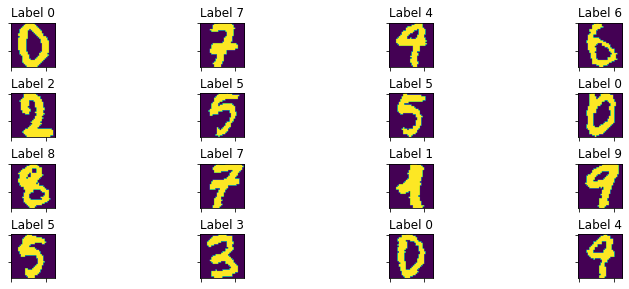

In [18]:
trainImages = ImageClass()
trainImages.readImages('data/digits-training.txt')
# display the 1st 16 images
trainImages.displayImages(range(0, 17))

load the test images

Image class init


'Loaded 943 images and 943 labels.'

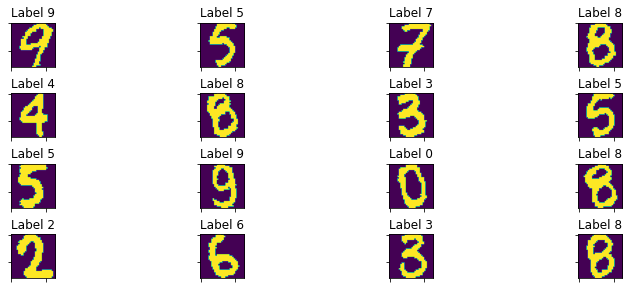

In [19]:
testImages = ImageClass()
testImages.readImages('data/digits-test.txt')
# display the 1st 16 images
testImages.displayImages(range(0, 17))

#### Notes
- The images are 32x32 pixels each, black/white (a pixel value of 0 = dark, 1 = bright)
- The arrangement of the images in the files is random.

#### Correlation tasks
Using this data, your task is to:

1. Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
3. Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.
4. Use the two-dimensional correlation function [`signal.correlate2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.
5. Implement variants of the digit recognition system, e.g.
    - use the negatives of the training and test images instead of the positive images
    - use images that are slightly rotated in your training set (using [`rotate`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate) from the `scikit-image.transform` library)
    - use images with some noise added in your training set (using [`random_noise`](https://scikit-image.org/docs/dev/api/skimage.util.html#random-noise) from the `scikit-image.util` library)
6. Report the accuracy of the new system and compare with the accuracy of the previous systems.
7. In the written report, discuss and reason about the different performances of your classifiers.

In [20]:
#
# CLass that encapsulates the image correlation functionality: 2 correlation versions are available:
# one is using a simple correlation implementation (correlate()), the other uses signal.correlate2d()
#
class ImageCorrelation:

    def __init__(self):
        print("ImageCorrelation init")
    #
    # 1. 1.	Create a function for comparing each test image with the collection of training images, using the correlation
    # with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
    #  pixels1, pixels2 images pixel arrays to correlate
    # return correlation value
    def correlate(self, pixels1, pixels2):
        # the two images are the same size so the size of one is used
        # to iterate over each pixel of both images
        imageShape = pixels1.shape
        correlation = 0
        for y in range(0, imageShape[0]):
            for x in range(0, imageShape[1]):
                correlation = correlation + (pixels1[y,x] * pixels2[y,x])
        return correlation

    #
    # 2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
    # correlate all images in imagesArray to the singleImage.
    # return the index (in imagesArray) of the image which has the
    # largest correlation value
    # singleTrainingDigitPixels training image pixels array
    # testDigitsPixels array of test images pixels array to correlate against
    # return the testImagesArray index of the best match found
    def correlateImagesToSingleImage(self, singleTrainingDigitPixels, testDigitsPixels):
        correlation = []
        # for each test image
        for imageIndex in range(0, len(testDigitsPixels)):
            # calculate the correlation with the singleTrainingImage and save it in correlation[]
            correlation.append(self.correlate(singleTrainingDigitPixels, testDigitsPixels[imageIndex]))
        # find the maximum correlation
        maxCorrelation = max(correlation)
        # using the max correlation value, find the index of it in correlation[]
        maxCorrelationImageIndex = correlation.index(maxCorrelation)
        return maxCorrelationImageIndex


    #
    # correlate using the correlation method in this class all training images with all test images
    # trainingImages class instance with the relevant training images to correlate (in digiPixels)
    # testImages class instance with all the test images
    # return array of best matches as indeces into the test images for each of the training images
    def correlateTrainingImagesToTestImages(self, trainingImages, testImages):
        #print("correlateTrainingImagesToTestImages({}, {})".format(len(trainingImages), len(testImages)))
        image2CorrelationIndeces = []
        # for each training image
        for imageIndex in range(0, len(trainingImages.digitPixels)):
            # find the best match in the test images using correlate(), store the result in image2CorrelationIndeces
            image2CorrelationIndeces.append(
                self.correlateImagesToSingleImage(trainingImages.digitPixels[imageIndex], testImages.digitPixels))
        # return array of best match found in testImages, one perTrainingImages[] entry
        return image2CorrelationIndeces

    # 3.	Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total
    # number of test images.
    # trainToTestCorrelationIndeces an indeces array of training predictions: each entry contains the index of the
    #                       predicted label in testLabels
    # trainingImages class instance that has an array of the training image labels
    # testImages class instance that has an array of the test labels
    # returns overall accuracy as correctly estimated count / the number of  entries in trainToTestCorrelationIndeces
    def calculateCorrelationAccuracy(self, trainToTestCorrelationIndeces, trainingImages, testImages):
        trainingLabels = trainingImages.digitLabels
        testLabels = testImages.digitLabels
        correctlyEstimatedCount = 0
        for labelsIndex in range(0, len(trainToTestCorrelationIndeces)  ):
            testLabelsIndex = trainToTestCorrelationIndeces[labelsIndex]
            if trainingLabels[labelsIndex] == testLabels[testLabelsIndex]:
                correctlyEstimatedCount =  correctlyEstimatedCount + 1
        return correctlyEstimatedCount / len(trainingLabels)

    #
    # Find the best 2d correlation between the singleTestImage and all the testImages,
    # Use the two-dimensional correlation function signal.correlate2d to find the best match over
    # all image offsets.
    # singleTrainingDigitPixels a single training image digitPixels array
    # testDigitsPixels an array of all the test images digitPixels, each one a 32x32 array
    # return the testImagesArray index with the best correlation
    def calculate2dCorrelation(self, singleTrainingDigitPixels, testDigitsPixels):
        correlations = []
        # for each test image
        for imageIndex in range(0, len(testDigitsPixels)):
            currentTestDigitPixels = testDigitsPixels[imageIndex]
            # correlate test image with training image
            result = sig.correlate2d(singleTrainingDigitPixels, currentTestDigitPixels, mode='same')
            # extract and store in correlations the largest correlation value found
            bestCorrelation = np.amax(result)
            correlations.append(bestCorrelation)
        maxOverallCorrelation = max(correlations)
        maxCorrelationImageIndex = correlations.index(maxOverallCorrelation)
        return maxCorrelationImageIndex

    # Find the best 2d correlation between the singleTestImage and all the testImages,
    # For efficiency you can use a subset of the training images
    # trainingImages training images class instance that holds the relevant training images
    # testImages test image class instance that holds all the test images
    def correlate2dTrainingImagesToTestImages(self, trainingImages, testImages):
        image2CorrelationIndeces = []
        for imageIndex in range(0, len(trainingImages.digitPixels)):
            image2CorrelationIndeces.append(
                self.calculate2dCorrelation(trainingImages.digitPixels[imageIndex], testImages.digitPixels))
        return image2CorrelationIndeces

    # perform simple correlation and 2d correlation of the training images aginast the test images
    # returns 2 values: the overall simple correlation accuracy and the overall 2d correlation accuracy
    def compareImageCorrelations(self, trainingImages, testImages):
        simpleCorrelationIndeces = self.correlateTrainingImagesToTestImages(trainingImages, testImages)
        c2dCorrelationIndeces = self.correlate2dTrainingImagesToTestImages(trainingImages, testImages)
        simpleCorrelationAccuracy = self.calculateCorrelationAccuracy(simpleCorrelationIndeces, trainingImages, testImages)
        c2dCorrelationAccuracy = self.calculateCorrelationAccuracy(c2dCorrelationIndeces, trainingImages, testImages)
        return simpleCorrelationAccuracy, c2dCorrelationAccuracy

#### Correlation of each training image to each test image
1. Create a function for comparing each test image with the collection of training images, using the correlation
   with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
3. Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.

In [21]:
# create an image correlation class
imageCorrelation = ImageCorrelation()
# calculate correlation of training images to test images, into an array, one entry per trainImage, set to the index best match found
# in the testImages
bestMatchTestImageIndeces = imageCorrelation.correlateTrainingImagesToTestImages(trainImages, testImages)
# calculate overall accuracy
overallCorrelationAccuracy = imageCorrelation.calculateCorrelationAccuracy(bestMatchTestImageIndeces, trainImages, testImages)
print("Overall correlation accuracy: ", overallCorrelationAccuracy)

ImageCorrelation init
Overall correlation accuracy:  0.8479834539813857


The overall correlation accuracy is noted

4. Use the two-dimensional correlation function
   [`signal.correlate2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   to find the best match over all image offsets. For efficiency you can use a subset of the training images,
   or calculate an average of the training images.

A subset of the training images (100 images) is used to correlate the training images against signal.correlate2d, over
all image offsets:

In [22]:
# create a subset of the training images by copying images at index 300 to 400 inclusive:
trainImageSubset = trainImages.copy(300,400)
print("Training image subset of {} images created.".format(len(trainImageSubset.digitPixels)))

# get the best match for each training subset image using 2d correlation
bestMatchTestImageIndeces = imageCorrelation.correlate2dTrainingImagesToTestImages(trainImageSubset, testImages)
# calculate overall accuracy
overallCorrelationAccuracy = imageCorrelation.calculateCorrelationAccuracy(bestMatchTestImageIndeces, trainImageSubset, testImages)
print("Overall correlation 2d accuracy: ", overallCorrelationAccuracy)

# get the best match for each training subset image using simple correlation
bestMatchTestImageIndeces = imageCorrelation.correlateTrainingImagesToTestImages(trainImageSubset, testImages)
# calculate overall accuracy
overallCorrelationAccuracy = imageCorrelation.calculateCorrelationAccuracy(bestMatchTestImageIndeces, trainImageSubset, testImages)
print("Overall simple correlation accuracy: ", overallCorrelationAccuracy)

Image class init
Training image subset of 100 images created.
Overall correlation 2d accuracy:  0.67
Overall simple correlation accuracy:  0.62


#### Compare variants of the digit recognition system

5. Implement variants of the digit recognition system.

#### negatives of the training and test images instead of the positive images

Negative Images

Training Images
Image class init


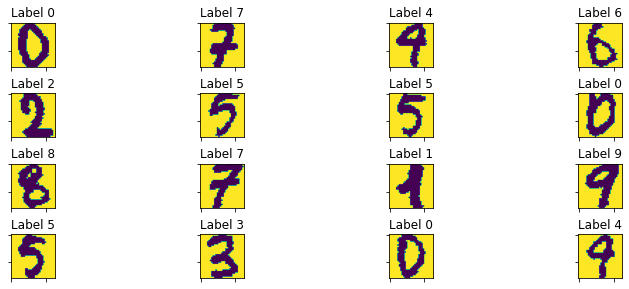

Test Images
Image class init


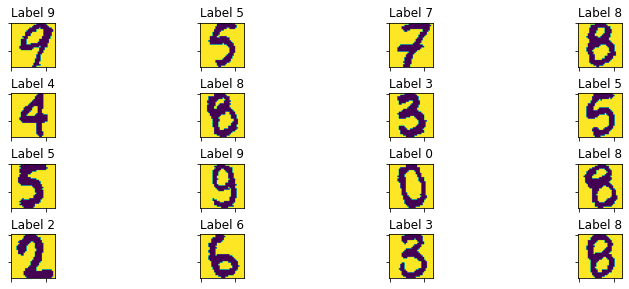

Accuracies: Corr: 0.93 2dCorr: 0.93


In [23]:
print("Negative Images\n")

# create negative version of a training image subset of 50 images
print("Training Images")
negTrain = trainImages.copy(0,100).convertImagesToNegativeImages()
negTrain.displayImages(range(0, 17))

print("Test Images")
# create a negative version of the test images
negTest =  testImages.copy().convertImagesToNegativeImages()
negTest.displayImages(range(0, 17))

# compare the simple correlation to the 2d correlation
simpleAccuracy, c2dAccuracy = imageCorrelation.compareImageCorrelations(negTrain, negTest)
print("Accuracies: Corr: {} 2dCorr: {}".format(simpleAccuracy, c2dAccuracy))

#### compare training images, rotated by 15 degrees, to the test set (not rotated) images

Rotated Images

Image class init


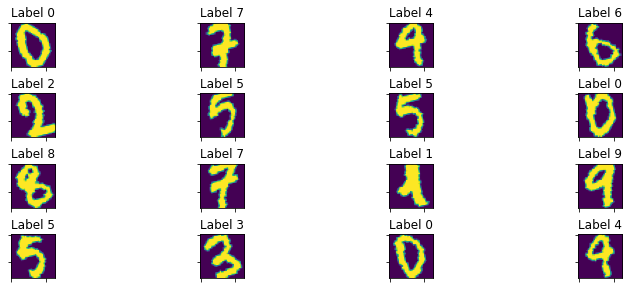

Accuracies: Corr: 0.68 2dCorr: 0.71


In [24]:
print("Rotated Images\n")

# create a rotated version of a training image subset of 50 images
rotTrain = trainImages.copy(0,100).rotateImages(15)
rotTrain.displayImages(range(0, 17))

# compare the simple correlation to the 2d correlation
simpleAccuracy, c2dAccuracy = imageCorrelation.compareImageCorrelations(rotTrain, testImages)
print("Accuracies: Corr: {} 2dCorr: {}".format(simpleAccuracy, c2dAccuracy))

#### compare training images, with random noise added, to the test set (no noise) images

Noisy Images

Image class init


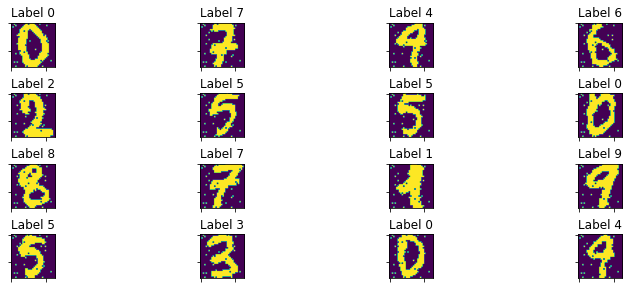

Accuracies: Corr: 0.89 2dCorr: 0.91


In [25]:
print("Noisy Images\n")

# create subset of noisy training images
noiseTrain = trainImages.copy(0, 100).addNoiseToImages(5)
noiseTrain.displayImages(range(0, 17))

# compare the simple correlation to the 2d correlation
simpleAccuracy, c2dAccuracy = imageCorrelation.compareImageCorrelations(noiseTrain, testImages)
print("Accuracies: Corr: {} 2dCorr: {}".format(simpleAccuracy, c2dAccuracy))

#### compare training images, with offset added, to the test set (no offset added)

Offset Images

Image class init


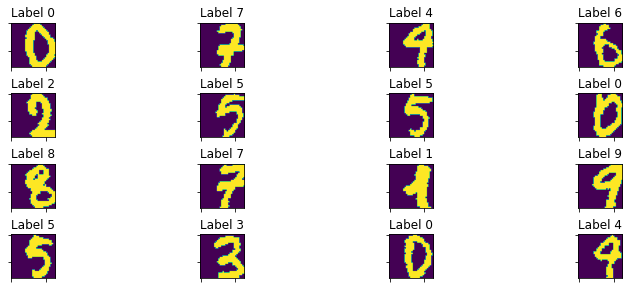

Accuracies: Corr: 0.27 2dCorr: 0.91


In [26]:
print("Offset Images\n")
# create subset of offset training images (shifted 5 pixels to the right, 1 pixel down)
offsetTrain = trainImages.copy(0, 100).offSetImages(5, 1)
offsetTrain.displayImages(range(0, 17))

# compare the simple correlation to the 2d correlation
simpleAccuracy, c2dAccuracy = imageCorrelation.compareImageCorrelations(offsetTrain, testImages)
print("Accuracies: Corr: {} 2dCorr: {}".format(simpleAccuracy, c2dAccuracy))

#### compare training images, rotated by 15 degrees, with noise added, to the test set (no alterations done)

Rotated & Noise to training images

Image class init


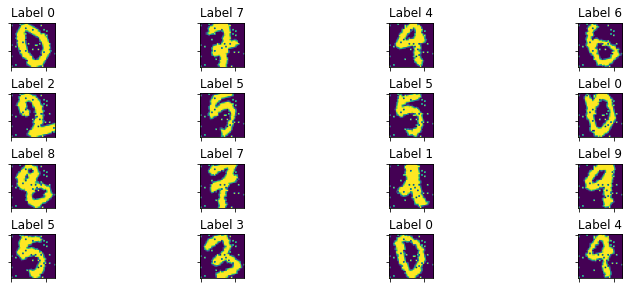

Accuracies: Corr: 0.66 2dCorr: 0.69


In [27]:
print("Rotated & Noise to training images\n")
# create subset of offset training images (shifted 5 pixels to the right, 1 pixel down)
rotNoiseTrain = trainImages.copy(0, 100).rotateImages(15).addNoiseToImages(10)
rotNoiseTrain.displayImages(range(0, 17))

# compare the simple correlation to the 2d correlation
simpleAccuracy, c2dAccuracy = imageCorrelation.compareImageCorrelations(rotNoiseTrain, testImages)
print("Accuracies: Corr: {} 2dCorr: {}".format(simpleAccuracy, c2dAccuracy))

## Time series prediction with financial data (UG pairs & PG)

In this part, you're going to use long term US stock market data (monthly indices, dividends, earnings, etc. since 1871). Information about the data provenance and references can be found at http://www.econ.yale.edu/~shiller/data.htm (especially the 2nd paragraph). The data is available in the file `data/financial_data.csv`.

It is stored as comma-separated numerical values, with a header containing column names. Therefore we can use [`np.genfromtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) to read it.

In [48]:
financial = np.genfromtxt('data/financial_data.csv', delimiter=',', skip_header=2, names=True)

The result is a structured array, which means that we can access each of the columns in the table by its name. The list of all colums can be found below.

In [49]:
financial.dtype.names

('Date',
 'SP_Comp_P',
 'Dividend_D',
 'Earnings_E',
 'Consumer_Price_Index_CPI',
 'Date_Fraction',
 'Long_Interest_Rate_GS10',
 'Real_Price',
 'Real_Dividend',
 'Real_Earnings',
 'Cyclically_Adjusted_Price_Earnings_Ratio_PE10_or_CAPE')

You can access the columns using their names between square brackets, like you would for a dictionary. It's advised to store the columns you need in helper variables, to avoid long statements resulting from the long column names.

In [50]:
date = financial['Date']
real_price = financial['Real_Price']

Now you can easily use the data, for instance to plot it.

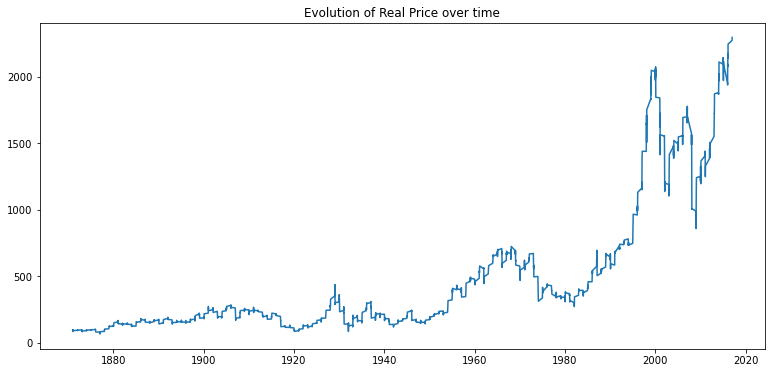

In [51]:
plt.figure()
plt.plot(date, real_price)
plt.title('Evolution of Real Price over time')
plt.show()

Using this data, your task is to:

1. Look for long term trends on a linear and log scale and de-trend the data first.
2. Calculate the FFT of the signal of interest, to estimate possible periodicities. You can use a window to avoid spectral leaking.
3. Refine your analysis by adjusting the size of the dataset (e.g. if you model annual patterns, make sure your dataset size is a multiple of 12).

In [52]:
# write your code here